# Transformation code $\rightarrow$ graphs (AST, CFG)

Pour faire il y a deux approches,  
- utiliser **slither** qui a déjà une fonction implémentée pour donner la représentation en graphe du code solidity 
- le faire nous même 

On va utiliser le code `./data/example.sol` pour essayer de récupérer son graphe correspondant.  

## Méthode Slither

On commence avec la méthode slither. On exécute seulement la commande suivante :   
```
slither ./data/example.sol --print cfg  
```  

Et on a pleins de fichier `.dot` qui correspondent à une fonction (important pour la suite). Pour l'instant, j'aimerai juste visualiser l'une d'entre elle pour voir comment ça se comporte.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from transformers import AutoTokenizer, AutoModel
import torch
import tree_sitter_solidity as tssoldity
from tree_sitter import Language, Parser
import torch.nn as nn
import numpy as np
import seaborn as sns

In [4]:
def dessiner_graphe(chemin_dot):
    # Charger le graphe depuis le fichier .dot
    graphs = nx.drawing.nx_pydot.read_dot(chemin_dot)
    
    # Si le fichier contient plusieurs graphes, on prend le premier
    if isinstance(graphs, list):
        G = graphs[0]
    else:
        G = graphs

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Algorithme de positionnement des nœuds
    
    # Dessiner les nœuds et les arêtes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            edge_color='gray', node_size=2000, font_size=10)
    
    plt.title(f"Visualisation du CFG : {chemin_dot}")
    plt.show()

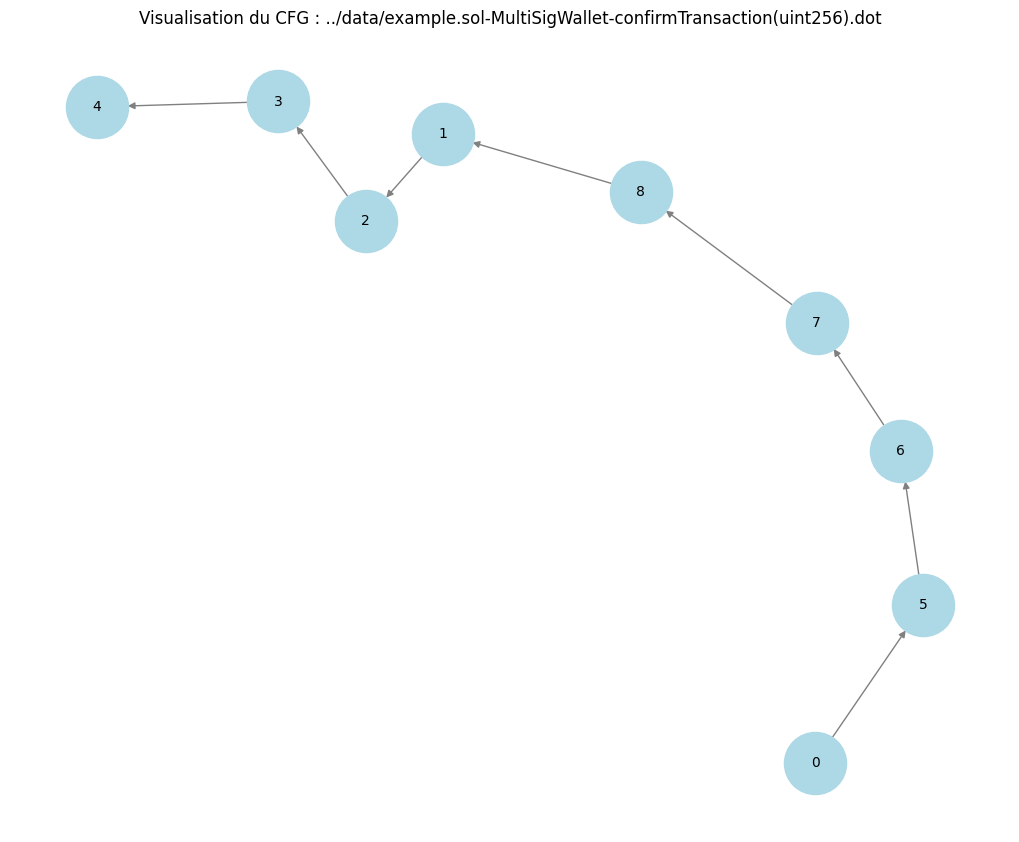

In [5]:
dessiner_graphe("../data/example.sol-MultiSigWallet-confirmTransaction(uint256).dot")

C'est un simple CFG d'une fonction. maintenant on va implémenter **GraphCodeBERT** qui semble aussi bien intéressant 

## GraphCodeBERT

GraphCodeBERT prend exactement : le code `.sol` et le data flow du code. pour avoir le data flow le papier suggère de passer par `tree-sitter`

In [6]:

# Charger la langue Solidity
SOL_LANGUAGE = Language(tssoldity.language())
parser = Parser(SOL_LANGUAGE)

def get_ast(source_code):
    tree = parser.parse(bytes(source_code, "utf8"))
    return tree

/tmp/ipykernel_10825/1051305945.py:2: DeprecationWarning: int argument support is deprecated
  SOL_LANGUAGE = Language(tssoldity.language())


## Data flow

In [7]:
def get_variable_nodes(node, variables):
    # On cherche les identifiants qui servent de variables
    if node.type == 'identifier' and node.child_count == 0:
        variables.append(node)
    for child in node.children:
        get_variable_nodes(child, variables)
    return variables

In [8]:
def extract_data_flow_edges(node, edges):
    # 1. On garde l'assignation classique (x = y)
    if node.type == 'assignment_expression':
        left_node = node.child_by_field_name('left')
        right_node = node.child_by_field_name('right')
        add_edges(left_node, right_node, edges)
    
    # 2. AJOUT : On capture les déclarations (uint x = a)
    elif node.type == 'variable_declaration_statement':
        # Dans Solidity, la structure est souvent : uint x = a;
        # On cherche l'identifiant à gauche et l'expression à droite
        declarations = []
        get_variable_nodes(node, declarations) # Trouve x et a
        if len(declarations) >= 2:
            # On lie les sources (a) vers la cible (x)
            target = declarations[0]
            sources = declarations[1:]
            for s in sources:
                edges.append((s.id, target.id))

    for child in node.children:
        extract_data_flow_edges(child, edges)

def add_edges(lhs, rhs, edges):
    if lhs and rhs:
        lhs_vars = get_variable_nodes(lhs, [])
        rhs_vars = get_variable_nodes(rhs, [])
        for source in rhs_vars:
            for target in lhs_vars:
                edges.append((source.id, target.id))

## Code solidity de test

In [9]:
code_solidity = """
contract Simple {
    function compute(uint a, uint b) public pure returns (uint) {
        uint x = a + 1;
        uint y = b;
        uint z = x + y;
        return z;
    }
}
"""

## AST

In [10]:
# 1. Obtenir l'AST
tree = get_ast(code_solidity)
root = tree.root_node

# 2. Récupérer toutes les occurrences de variables
all_vars = get_variable_nodes(root, [])
print(f"Nombre de variables trouvées : {len(all_vars)}")

# 3. Extraire les arêtes du Data Flow
flow_edges = []
extract_data_flow_edges(root, flow_edges)

# 4. Affichage des résultats
print("\nArêtes du Data Flow (ID Source -> ID Cible) :")
for edge in flow_edges:
    # Récupérer le nom pour l'affichage
    src_name = next(v.text.decode('utf8') for v in all_vars if v.id == edge[0])
    tgt_name = next(v.text.decode('utf8') for v in all_vars if v.id == edge[1])
    print(f" {src_name} ({edge[0]}) ---> {tgt_name} ({edge[1]})")

Nombre de variables trouvées : 12

Arêtes du Data Flow (ID Source -> ID Cible) :
 a (140683296553552) ---> x (140683296553464)
 b (140683296554512) ---> y (140683296554424)
 x (140683295113456) ---> z (140683295113368)
 y (140683295113552) ---> z (140683295113368)


## Visualisation du graphs de variables

In [11]:
def visualiser_data_flow(all_vars, flow_edges):
    # 1. Créer un graphe dirigé
    G = nx.DiGraph()

    # 2. Ajouter les nœuds avec leurs noms comme labels
    # Note : On ajoute la position (ligne, colonne) pour distinguer 
    # les différentes occurrences d'une même variable
    labels = {}
    for var in all_vars:
        var_name = var.text.decode('utf8')
        line = var.start_point[0]
        col = var.start_point[1]
        
        node_label = f"{var_name}\n(L{line}:C{col})"
        G.add_node(var.id, label=node_label)
        labels[var.id] = node_label

    # 3. Ajouter les arêtes "Value comes from"
    G.add_edges_from(flow_edges)

    # 4. Mise en page et dessin
    plt.figure(figsize=(8, 4))
    
    # Utilisation d'un layout hiérarchique ou printanier
    pos = nx.spring_layout(G, k=1.5) 
    
    nx.draw(G, pos, labels=labels, with_labels=True, 
            node_color='lightgreen', edge_color='skyblue', 
            node_size=2000, font_size=8, font_weight='bold',
            arrowsize=20, arrowstyle='->')

    plt.title("Data Flow Graph - Méthode GraphCodeBERT\n(Les flèches indiquent l'origine de la valeur)", fontsize=11)
    
    # Sauvegarde et affichage
    plt.savefig("data_flow_visualisation.png")
    plt.show()

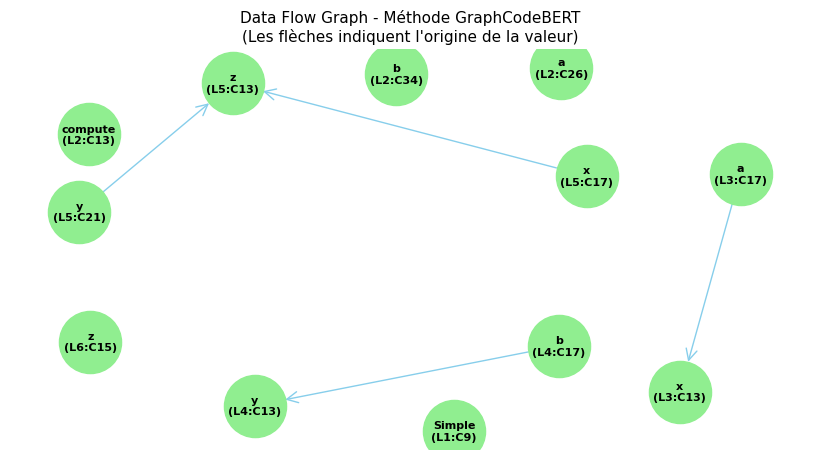

In [12]:
# Appel de la fonction avec vos données précédentes
visualiser_data_flow(all_vars, flow_edges)

On voit bien qu'il y a correspondance entre chaques variables (a vient de x, b vient de y et (x,y) vient de z)  
Maintenant, on va importer GraphsCodeBERT d'hugging face

Le modèle prend cet input :  
$$X = \{[CLS], W, [SEP], C, [SEP], V\}$$

Avec $W$ les commentaires ou les descriptions du code, $C$ le code solidity et $V$ la liste des var extrait par tree-sitter

## Modèle GraphsCodeBERT

In [13]:
# 1. Charger le tokenizer et le modèle GraphCodeBERT
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
model = AutoModel.from_pretrained("microsoft/graphcodebert-base")

# 2. Tokeniser le code
code_tokens = tokenizer.tokenize(code_solidity)
tokens = [tokenizer.cls_token] + code_tokens + [tokenizer.sep_token]
input_ids = tokenizer.convert_tokens_to_ids(tokens)

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 360.96it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: microsoft/graphcodebert-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.decoder.bias            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training o

### $V$

In [14]:
V = [v.text.decode('utf8') for v in all_vars]
print(V)

['Simple', 'compute', 'a', 'b', 'x', 'a', 'y', 'b', 'z', 'x', 'y', 'z']


### Matrice d'attention ($M$) 

In [15]:
def build_graph_mask(input_ids, code_indices, var_indices, flow_edges, alignment_edges):
    """
    input_ids: IDs des tokens [CLS, code..., SEP, vars..., SEP]
    code_indices: Liste des index de la séquence appartenant au code (C)
    var_indices: Liste des index de la séquence appartenant aux variables (V)
    flow_edges: Liste de tuples (idx_source, idx_cible) dans var_indices
    alignment_edges: Liste de tuples (idx_var, idx_code)
    """
    seq_len = len(input_ids)
    # Initialiser avec une valeur très négative (interdit)
    mask = torch.full((seq_len, seq_len), -1e9)

    # --- RÈGLE 1 : CLS, SEP et Code ---
    # Ces tokens peuvent tout voir et être vus par tout le monde (optionnel selon implémentation)
    # Le papier indique surtout que Code-Code est autorisé
    special_indices = [0, code_indices[-1] + 1, seq_len - 1] # [CLS], [SEP], [SEP]
    allowed_text = special_indices + code_indices
    
    for i in allowed_text:
        mask[i, allowed_text] = 0

    # --- RÈGLE 2 : Data Flow (E) ---
    # Une variable i attend la source j dont elle provient
    for i in var_indices:
        mask[i, i] = 0 # Auto-attention (i=j)
        
    for src_idx, tgt_idx in flow_edges:
        # src_idx et tgt_idx doivent être les index réels dans la séquence
        mask[tgt_idx, src_idx] = 0 

    # --- RÈGLE 3 : Alignement (E') ---
    # Lien bidirectionnel entre le nœud du graphe et le mot dans le code
    for var_idx, code_idx in alignment_edges:
        mask[var_idx, code_idx] = 0
        mask[code_idx, var_idx] = 0

    return mask

## Test de la matrice d'attention

In [16]:
# --- CAS DE TEST : x = y ---
# Séquence : [CLS], x, =, y, [SEP], x_v, y_v, [SEP]
# Index :     0,   1, 2, 3,   4,    5,   6,    7
input_ids = [0] * 8 
code_indices = [1, 2, 3] # x, =, y
var_indices = [5, 6]    # x_v, y_v

# Flux de données : la valeur de y (index 6) va vers x (index 5)
flow_edges = [(6, 5)] 

# Alignement : x_v (5) lié au token x (1), y_v (6) lié au token y (3)
alignment_edges = [(5, 1), (6, 3)]

# Appel de votre fonction
mask = build_graph_mask(input_ids, code_indices, var_indices, flow_edges, alignment_edges)

# --- VÉRIFICATIONS ---
def check(condition, message):
    print(f"{'[OK]' if condition else '[ERREUR]'} {message}")

# Règle 1 : Le code peut voir le code (Attention classique)
check(mask[1, 3] == 0, "Le token 'x' (1) peut voir le token 'y' (3)")

# Règle 2 : Data Flow (La cible voit la source)
check(mask[5, 6] == 0, "La variable cible 'x' (5) peut voir sa source 'y' (6)")
check(mask[6, 5] < 0, "La variable source 'y' (6) NE PEUT PAS voir sa cible 'x' (5)")

# Règle 3 : Alignement (Le noeud voit son mot dans le code)
check(mask[5, 1] == 0, "Le noeud 'x' (5) peut voir le mot 'x' (1) dans le code")
check(mask[1, 5] == 0, "Le mot 'x' (1) peut voir son noeud 'x' (5) dans le graphe")

[OK] Le token 'x' (1) peut voir le token 'y' (3)
[OK] La variable cible 'x' (5) peut voir sa source 'y' (6)
[OK] La variable source 'y' (6) NE PEUT PAS voir sa cible 'x' (5)
[OK] Le noeud 'x' (5) peut voir le mot 'x' (1) dans le code
[OK] Le mot 'x' (1) peut voir son noeud 'x' (5) dans le graphe


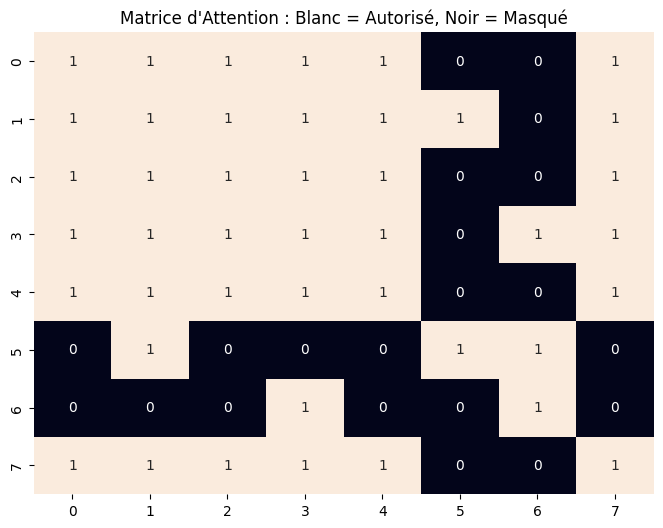

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(mask.numpy() == 0, cbar=False, annot=True)
plt.title("Matrice d'Attention : Blanc = Autorisé, Noir = Masqué")
plt.show()

### formattage des entrées (tenseurs) pour le modèle

In [18]:
input_ids_tensor = torch.tensor([input_ids])
attention_mask_tensor = mask.unsqueeze(0).unsqueeze(0)
print(input_ids_tensor.shape)
print(attention_mask_tensor.shape)

torch.Size([1, 8])
torch.Size([1, 1, 8, 8])


In [19]:
# 2. Passage dans le modèle (Inférence)
model.eval() # Mode évaluation
with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
# outputs.last_hidden_state contient les vecteurs (embeddings) pour chaque token
# Shape: (Batch_Size, Seq_Len, Hidden_Size=768)
sequence_embedding = outputs.last_hidden_state

In [20]:
# 3. Récupération du vecteur [CLS] (le résumé du code)
# Index 0 sur la dimension séquence
cls_vector = sequence_embedding[:, 0, :]  # Shape (1, 768)
print(f"Vecteur représentant le code (taille 768) : {cls_vector.shape}")
# 4. Simulation d'un classifieur (à entraîner plus tard)
# Imaginons 2 classes : 0 = Sain, 1 = Fraude
num_labels = 5
classifier = nn.Linear(768, num_labels)
# Prédiction (Logits)
logits = classifier(cls_vector)
probs = torch.softmax(logits, dim=-1)
print(f"Probabilités [Sain, Fraude] (non entraîné) : {probs}")

Vecteur représentant le code (taille 768) : torch.Size([1, 768])
Probabilités [Sain, Fraude] (non entraîné) : tensor([[0.1794, 0.1832, 0.2593, 0.1912, 0.1869]], grad_fn=<SoftmaxBackward0>)


TODO pour la suite:  
- comprendre en détail le mécanisme de graphscodebert
- finetuner le modèle pour notre cas à nous
- mettre au propre un notebook de test
- tester notre modèle sur des vrais codes